In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [394]:
df = pd.read_csv("./dataset/Reviews.csv")

In [395]:
df.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [3]:
df.shape

(568454, 10)

In [8]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

##### Taking only Text and Score columns for Sentiment Analysis

In [396]:
df = df[['Text', 'Score']]

In [397]:
df.head()

Text  Score
0  I have bought several of the Vitality canned d...      5
1  Product arrived labeled as Jumbo Salted Peanut...      1
2  This is a confection that has been around a fe...      4
3  If you are looking for the secret ingredient i...      2
4  Great taffy at a great price.  There was a wid...      5

In [11]:
df.shape

(568454, 2)

#### EDA

<Axes: xlabel='Score', ylabel='count'>

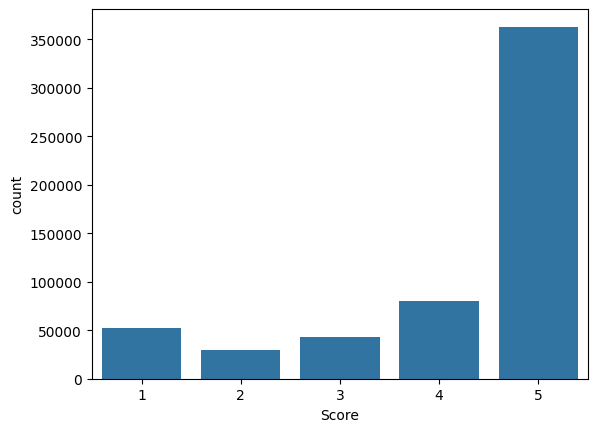

In [12]:
sns.barplot(df['Score'].value_counts())

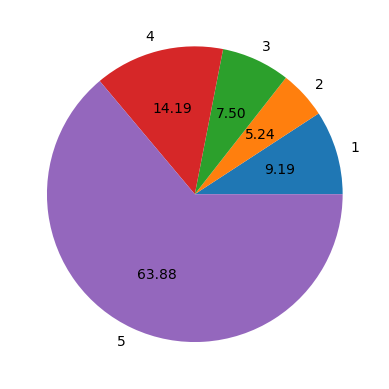

In [15]:
plt.pie(df['Score'].value_counts().sort_index(), labels=['1', '2', '3', '4', '5'], autopct='%.2f')
plt.show()

In [398]:
X = df.iloc[:, 0].values
y = df.iloc[:, -1].values

In [490]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [439]:
X_train = X_train.reshape(-1,1)

#### Resampling the training dataset to have equal number of instances in every class

In [440]:
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [441]:
pd.Series(y_train).value_counts()

1    26865
2    26865
3    26865
4    26865
5    26865
Name: count, dtype: int64

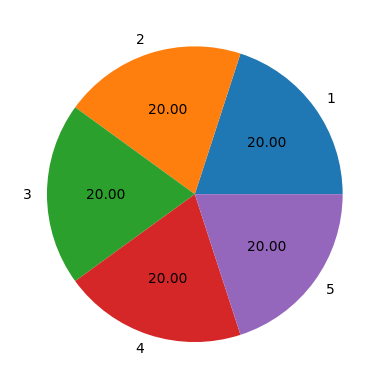

In [37]:
plt.pie(pd.Series(y_train).value_counts().sort_index(), labels=['1', '2', '3', '4', '5'], autopct='%.2f')
plt.show()

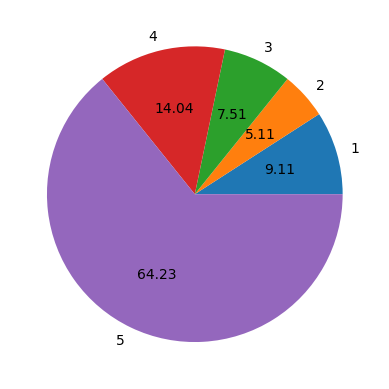

In [38]:
plt.pie(pd.Series(y_test).value_counts().sort_index(), labels=['1', '2', '3', '4', '5'], autopct='%.2f')
plt.show()

In [14]:
print(y_test.shape)
print(y_train.shape)

(56846,)
(134325,)


### Data Preprocessing
    1. lower case
    2. tokenization
    3. remove special characters
    4. remove stop words and punctuation
    5. stemming

In [104]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\paulb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [105]:
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\paulb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [442]:
df_train = pd.DataFrame(X_train, columns=['Text'])

In [443]:
df_train['Score'] = y_train

In [88]:
def transform_text(text):
    text = text.lower()   # lower casing
    text = nltk.word_tokenize(text)  # tokenization
    y = []
    for i in text:   # remove special characters
        if i.isalnum():
            y.append(i)
    text = y.copy()
    y.clear()
    for i in text:   # removing stopwords
        if i not in stopwords.words("english") :
            y.append(i)
    ps = PorterStemmer()  # for stemming
    text = y.copy()
    y.clear()
    for i in text:
        y.append(ps.stem(i))
    return " ".join(y)

In [16]:
df_train['transformed_text'] = df_train['Text'].apply(transform_text)

In [17]:
X_train = df_train['transformed_text'].values

In [23]:
X_test = pd.DataFrame(X_test, columns=['text'])['text'].apply(transform_text)


#### Viewing some most ocuring words from negative and positive sentiment reviews

In [81]:
from wordcloud import WordCloud
wc = WordCloud(height=1500, width=1500, background_color='white', min_font_size=10)

In [83]:
one_wc = wc.generate(df_train[df_train['Score']==1]['transformed_text'].str.cat(sep=" "))

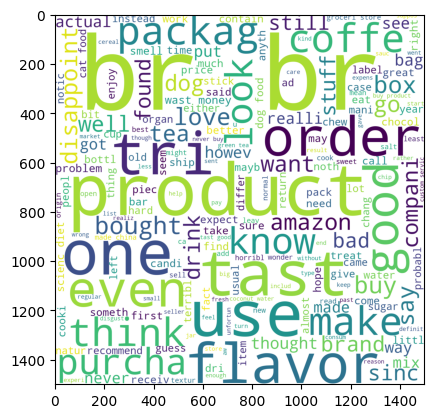

In [84]:
plt.imshow(one_wc)

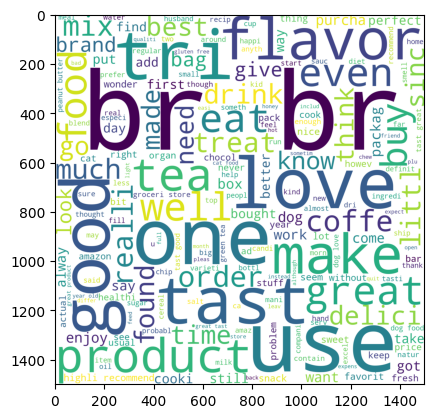

In [85]:
five_wc = wc.generate(df_train[df_train['Score']==5]['transformed_text'].str.cat(sep=" "))
plt.imshow(five_wc)

In [18]:
with open("training_dataset.pkl", "wb") as f:
    pickle.dump((X_train, y_train), f)
with open("testing_dataset.pkl", "wb") as f:
    pickle.dump((X_test, y_test), f)

In [388]:
with open("training_dataset.pkl", "rb") as f:
    (X_train, y_train) = pickle.load(f)
with open("testing_dataset.pkl", "rb") as f:
    (X_test, y_test) = pickle.load(f)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer(max_features=1000)
tv = TfidfVectorizer(max_features=1000)

## Countvectorizer

In [94]:
X_train_c = cv.fit_transform(X_train).toarray()
X_test_c = cv.transform(X_test).toarray()
dataset = np.append(X_train_c, np.array(y_train).reshape(-1,1), axis=1)
np.random.shuffle(dataset)  # shuffling the dataset
dataset.shape 
X_train_c = dataset[:, :-1]
y_train = dataset[:, -1]
y_train = np.array(y_train).reshape(-1)

y_train_indices = [True if (ele>=4 or ele<=2) else False for ele in y_train]  # not taking score=3 reviews in the dataset
y_test_indices = [True if (ele>=4 or ele<=2) else False for ele in y_test]    
X_train_c = X_train_c[y_train_indices]
y_train = y_train[y_train_indices]
X_test_c = X_test_c[y_test_indices]
y_test = y_test[y_test_indices]

y_train = [1 if i<3 else 0 for i in y_train]    # 1 is negative sentiment, 0 is positive sentiment
y_test = [1 if i<3 else 0 for i in y_test]

rus = RandomUnderSampler(random_state=42)   # reducing the dataset, as some ML algorithms take to much time
X_train_cr, y_train_r = rus.fit_resample(X_train_c[:25000], y_train[:25000])
dataset = np.append(X_train_cr, np.array(y_train_r).reshape(-1,1), axis=1)
np.random.shuffle(dataset)
dataset.shape
X_train_cr = dataset[:, :-1]
y_train_r = dataset[:, -1]

### SVM

0.8691492801308507


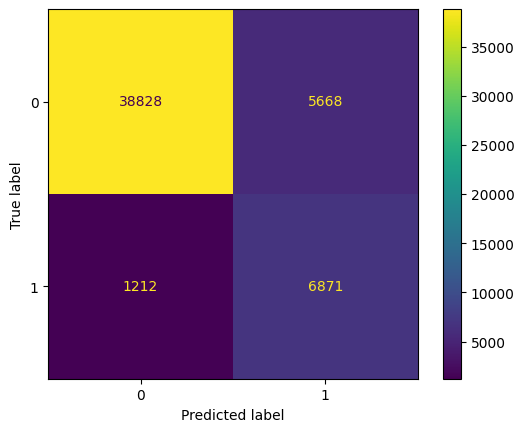

In [95]:
svm = SVC()
svm.fit(X_train_cr, y_train_r)
y_pred = svm.predict(X_test_c)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

#### Gaussian naive bayes

In [32]:
from sklearn.naive_bayes import GaussianNB

0.8385667281614333


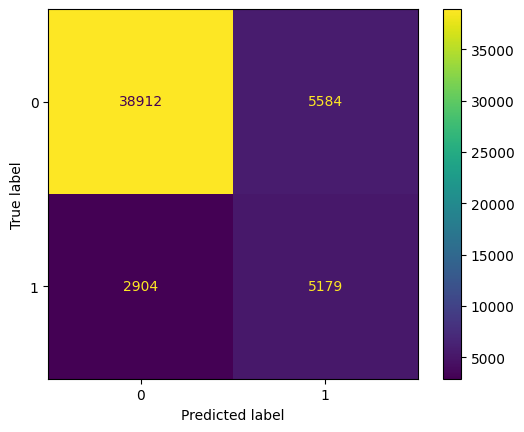

In [96]:
gnb = GaussianNB()
gnb.fit(X_train_c, y_train)
y_pred = gnb.predict(X_test_c)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## TfidfVectorizer

In [99]:
X_train_t = tv.fit_transform(X_train).toarray()
X_test_t = tv.transform(X_test).toarray()
dataset = np.append(X_train_t, np.array(y_train).reshape(-1,1), axis=1)
np.random.shuffle(dataset)
dataset.shape
X_train_t = dataset[:, :-1]
y_train = dataset[:, -1]
y_train = np.array(y_train).reshape(-1)
y_train_indices = [True if (ele>=4 or ele<=2) else False for ele in y_train]
y_test_indices = [True if (ele>=4 or ele<=2) else False for ele in y_test]
X_train_t = X_train_t[y_train_indices]
y_train = y_train[y_train_indices]
X_test_t = X_test_t[y_test_indices]
y_test = y_test[y_test_indices]
y_train = [1 if i<=3 else 0 for i in y_train]
y_test = [1 if i<=3 else 0 for i in y_test]
rus = RandomUnderSampler(random_state=42)
X_train_tr, y_train_r = rus.fit_resample(X_train_t[:25000], y_train[:25000])
dataset = np.append(X_train_tr, np.array(y_train_r).reshape(-1,1), axis=1)
np.random.shuffle(dataset)
dataset.shape
X_train_tr = dataset[:, :-1]
y_train_r = dataset[:, -1]

#### SVM

0.8774605831225394


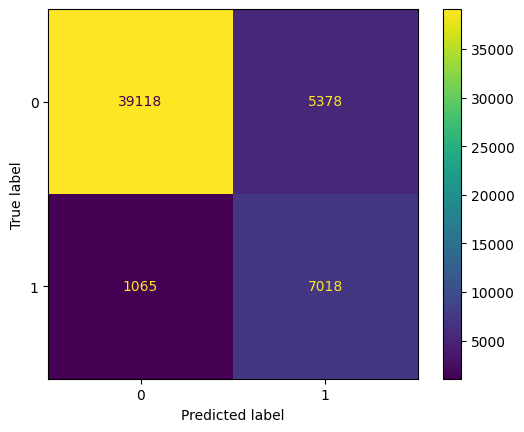

In [64]:
svm = SVC()
svm.fit(X_train_tr, y_train_r)
y_pred = svm.predict(X_test_t)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

0.8150021871849978


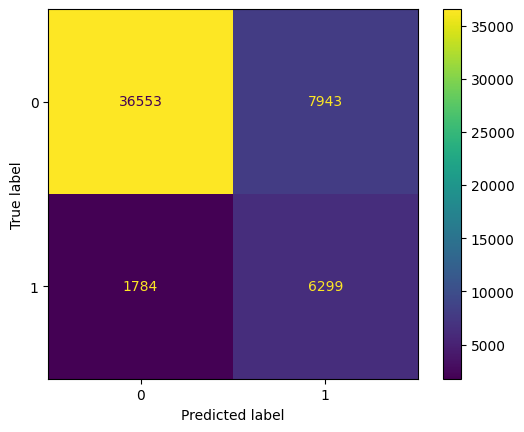

In [63]:
gnb = GaussianNB()
gnb.fit(X_train_t, y_train)
y_pred = gnb.predict(X_test_t)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

#### XGBoost

0.8590121531409879


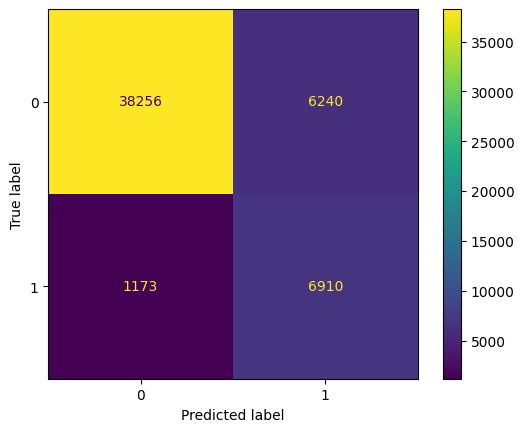

In [69]:
xgbc = XGBClassifier(n_estimators=200, subsample=0.8, learning_rate=0.1)
xgbc.fit(X_train_t, y_train)
y_pred = xgbc.predict(X_test_t)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

0.8856387531143612


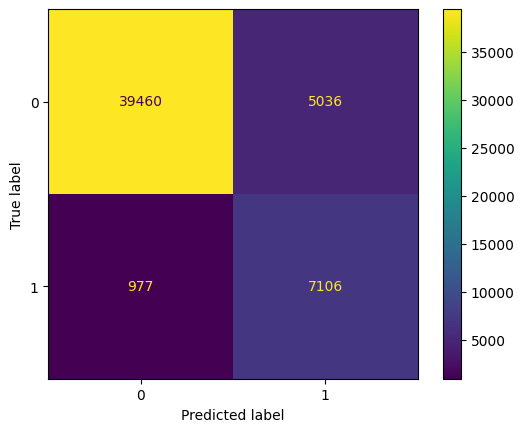

In [79]:
xgbc = XGBClassifier(n_estimators=550, subsample=0.8, learning_rate=0.1)
xgbc.fit(X_train_t, y_train)
y_pred = xgbc.predict(X_test_t)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

#### Catboost

0.869776907130223


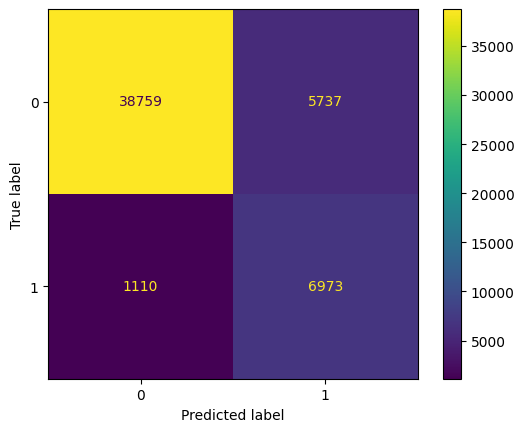

In [81]:
catb = CatBoostClassifier(n_estimators=400, max_depth=6, verbose=False, learning_rate=0.1)
catb.fit(X_train_t, y_train)
y_pred = catb.predict(X_test_t)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

#### lightGBM

0.8609520911390479


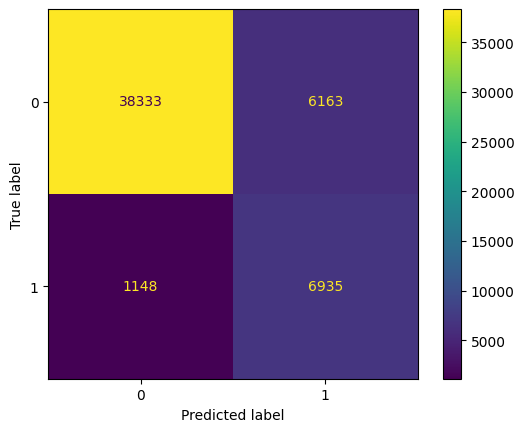

In [76]:
lgb = LGBMClassifier(n_estimators=222, num_leaves=40, max_depth=6, objective='binary', learning_rate=0.1, verbose=-1)
lgb.fit(X_train_t, y_train)
y_pred = lgb.predict(X_test_t)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Making the model for the webapp 
##### and taking XGBoost model for this

In [509]:
def transform_text(texts):
    transformed_texts = []
    for text in texts:
        text = text.lower()   # lower casing
        text = nltk.word_tokenize(text)  # tokenization
        y = []
        for i in text:   # remove special characters
            if i.isalnum():
                y.append(i)
        text = y.copy()
        y.clear()
        for i in text:   # removing stopwords
            if i not in stopwords.words("english") :
                y.append(i)
        ps = PorterStemmer()  # for stemming
        text = y.copy()
        y.clear()
        for i in text:
            y.append(ps.stem(i))
        transformed_texts.append(" ".join(y))
        
    transformed_texts = np.array(transformed_texts)
    return np.array(transformed_texts)

In [510]:
text_transformer = FunctionTransformer(transform_text)
tv = TfidfVectorizer(max_features=1000)
xgbc = XGBClassifier(n_estimators=450, subsample=0.8, learning_rate=0.1)

In [511]:
model = Pipeline([
    ('text_transformer', text_transformer),
    ('tv', tv),
    ('xgbc', xgbc)
])

In [494]:
X_train = df_train['Text'].values
y_train = df_train['Score'].values
dataset = np.append(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1), axis=1)
np.random.shuffle(dataset)
X_train = dataset[:, :-1]
y_train = dataset[:, -1]

y_train = np.array(y_train).reshape(-1)
y_train_indices = [True if (ele>=4 or ele<=2) else False for ele in y_train]
y_test_indices = [True if (ele>=4 or ele<=2) else False for ele in y_test]
X_train = X_train[y_train_indices]
y_train = y_train[y_train_indices]
X_test = X_test[y_test_indices]
y_test = y_test[y_test_indices]
y_train = [1 if i<3 else 0 for i in y_train]
y_test = [1 if i<3 else 0 for i in y_test]

In [459]:
pd.Series(y_train).value_counts()

0    173
1    151
Name: count, dtype: int64

In [499]:
X_test.shape

(52579,)

In [512]:
model.fit(np.array(X_train).reshape(-1), np.array(y_train).reshape(-1))

Pipeline(steps=[('text_transformer',
                 FunctionTransformer(func=<function transform_text at 0x000001C2405E6B90>)),
                ('tv', TfidfVectorizer(max_features=1000)),
                ('xgbc',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eva...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=450, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

0.8830521691169478


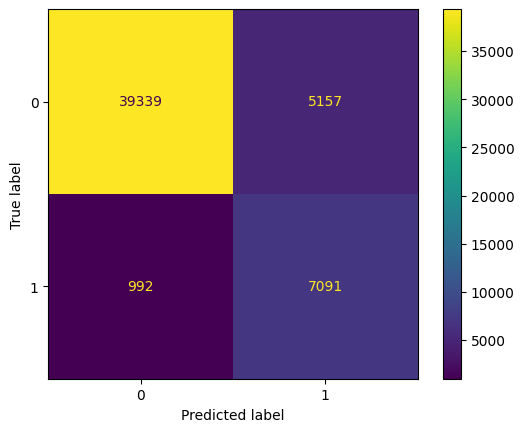

In [513]:
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [514]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)